In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import ensemble
from sklearn import svm, datasets
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, classification_report
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC 
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline

# Introduction

The dataset that I used for this capstone is useful for predicting whether or not a customer will leave the company/cancel their subscription, which is referred to as churn. In order to determine which model is most useful for this dataset and for predicting whether a customer will churn or not, I use two different techniques and compare multiple models. I first use selectKbest and fit logistic regression, KNN, decision tree, random forest, support vector, and gradient boosting models with the features chosen by selectKbest. Then, I use PCA and fit the same 6 models. Before fitting the models, I use gridsearchCV to determine which are the best parameters to use to fit the models. I compare each model's performance based on the following: cross-validation metrics, confusion matrices, and classification reports. 

# Data Exploration and Visualization

In [2]:
#load dataset
churn_df = pd.read_csv(
    r'C:\Users\Lowe\Documents\Thinkful\Datasets\WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
#examine first 5 rows
churn_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
#get the dataframe shape
churn_df.shape

(7043, 21)

In [5]:
#check for missing values
churn_df.isnull().sum()*100/churn_df.isnull().count()

customerID          0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

In [6]:
#check out the types of data
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

The majority of columns are not numeric. For some reason, TotalCharges is an object variable. This needs to be fixed.

In [7]:
#covnert Total Charges to numeric
churn_df['TotalCharges']=pd.to_numeric(churn_df.TotalCharges, errors='coerce')
#make sure it is numeric
churn_df['TotalCharges'].dtypes

dtype('float64')

Because I had to force the Total Charges column to be numeric, let's see if there are now any missing values in that column.

In [8]:
#check for missing values
churn_df['TotalCharges'].isnull().sum()

11

There are now 11 missing values in the Total Charges column. This is a very small number out of 7,043 observations. Let's just remove the rows with missing values.

In [9]:
#convert and drop missing rows
churn_df.replace(["NaN", 'NaT'], np.nan, inplace = True)
churn_df = churn_df.dropna()

In [10]:
#check for missing values
churn_df['TotalCharges'].isnull().any()

False

The missing values in the Total Charges column have been addressed

In [11]:
#get descriptive stats for numeric columns
churn_df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [12]:
#create list of the numeric columns
numeric_columns = churn_df.select_dtypes(['int64', 'float64']).columns
print(numeric_columns)

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')


In [13]:
#create list of non-numeric columns
non_numeric_columns = churn_df.select_dtypes(['object']).columns
#remove customerID and Churn
non_numeric_columns = non_numeric_columns.drop('customerID')
non_numeric_columns = non_numeric_columns.drop('Churn')
print(non_numeric_columns)

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')


In [14]:
#get ouliers for numeric columns
for col in numeric_columns:
    q75, q25 = np.percentile(churn_df[col], [75 ,25])
    iqr = q75 - q25


    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)

    print("The number of outliers for {} is: {}. This is {} percent of the column.".format(col, len((np.where((churn_df[col] > max_val) 
                      | (churn_df[col] < min_val))[0])), len((np.where((churn_df[col] > max_val) | 
                                                    (churn_df[col] < min_val))[0]))*100/1987))

The number of outliers for SeniorCitizen is: 1142. This is 57.47357825868143 percent of the column.
The number of outliers for tenure is: 0. This is 0.0 percent of the column.
The number of outliers for MonthlyCharges is: 0. This is 0.0 percent of the column.
The number of outliers for TotalCharges is: 0. This is 0.0 percent of the column.


Luckily, only SeniorCitizen has outliers, but this is a binary variable, so these outliers are not meaningful and do not need to be addressed. We can move on without having to address any outlier issues.

Let's visually explore how the categorical variables relate to the target variable churn. First, it is necessary to convert the categorical variable Churn to a numeric one. 

In [15]:
# convert churn to numeric variable:
target_map = {'Yes':1, 'No':0}
churn_df["churn_numeric"] = churn_df["Churn"].apply(lambda x: target_map[x])

In [16]:
#see how churn is distributed
churn_df['churn_numeric'].value_counts()

0    5163
1    1869
Name: churn_numeric, dtype: int64

Text(0, 0.5, 'Number of Customers')

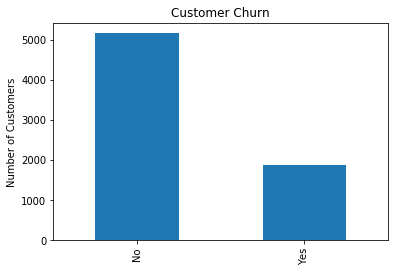

In [17]:
#plot value counts
churn_df['Churn'].value_counts().plot(kind='bar')
plt.title('Customer Churn')
plt.ylabel('Number of Customers')


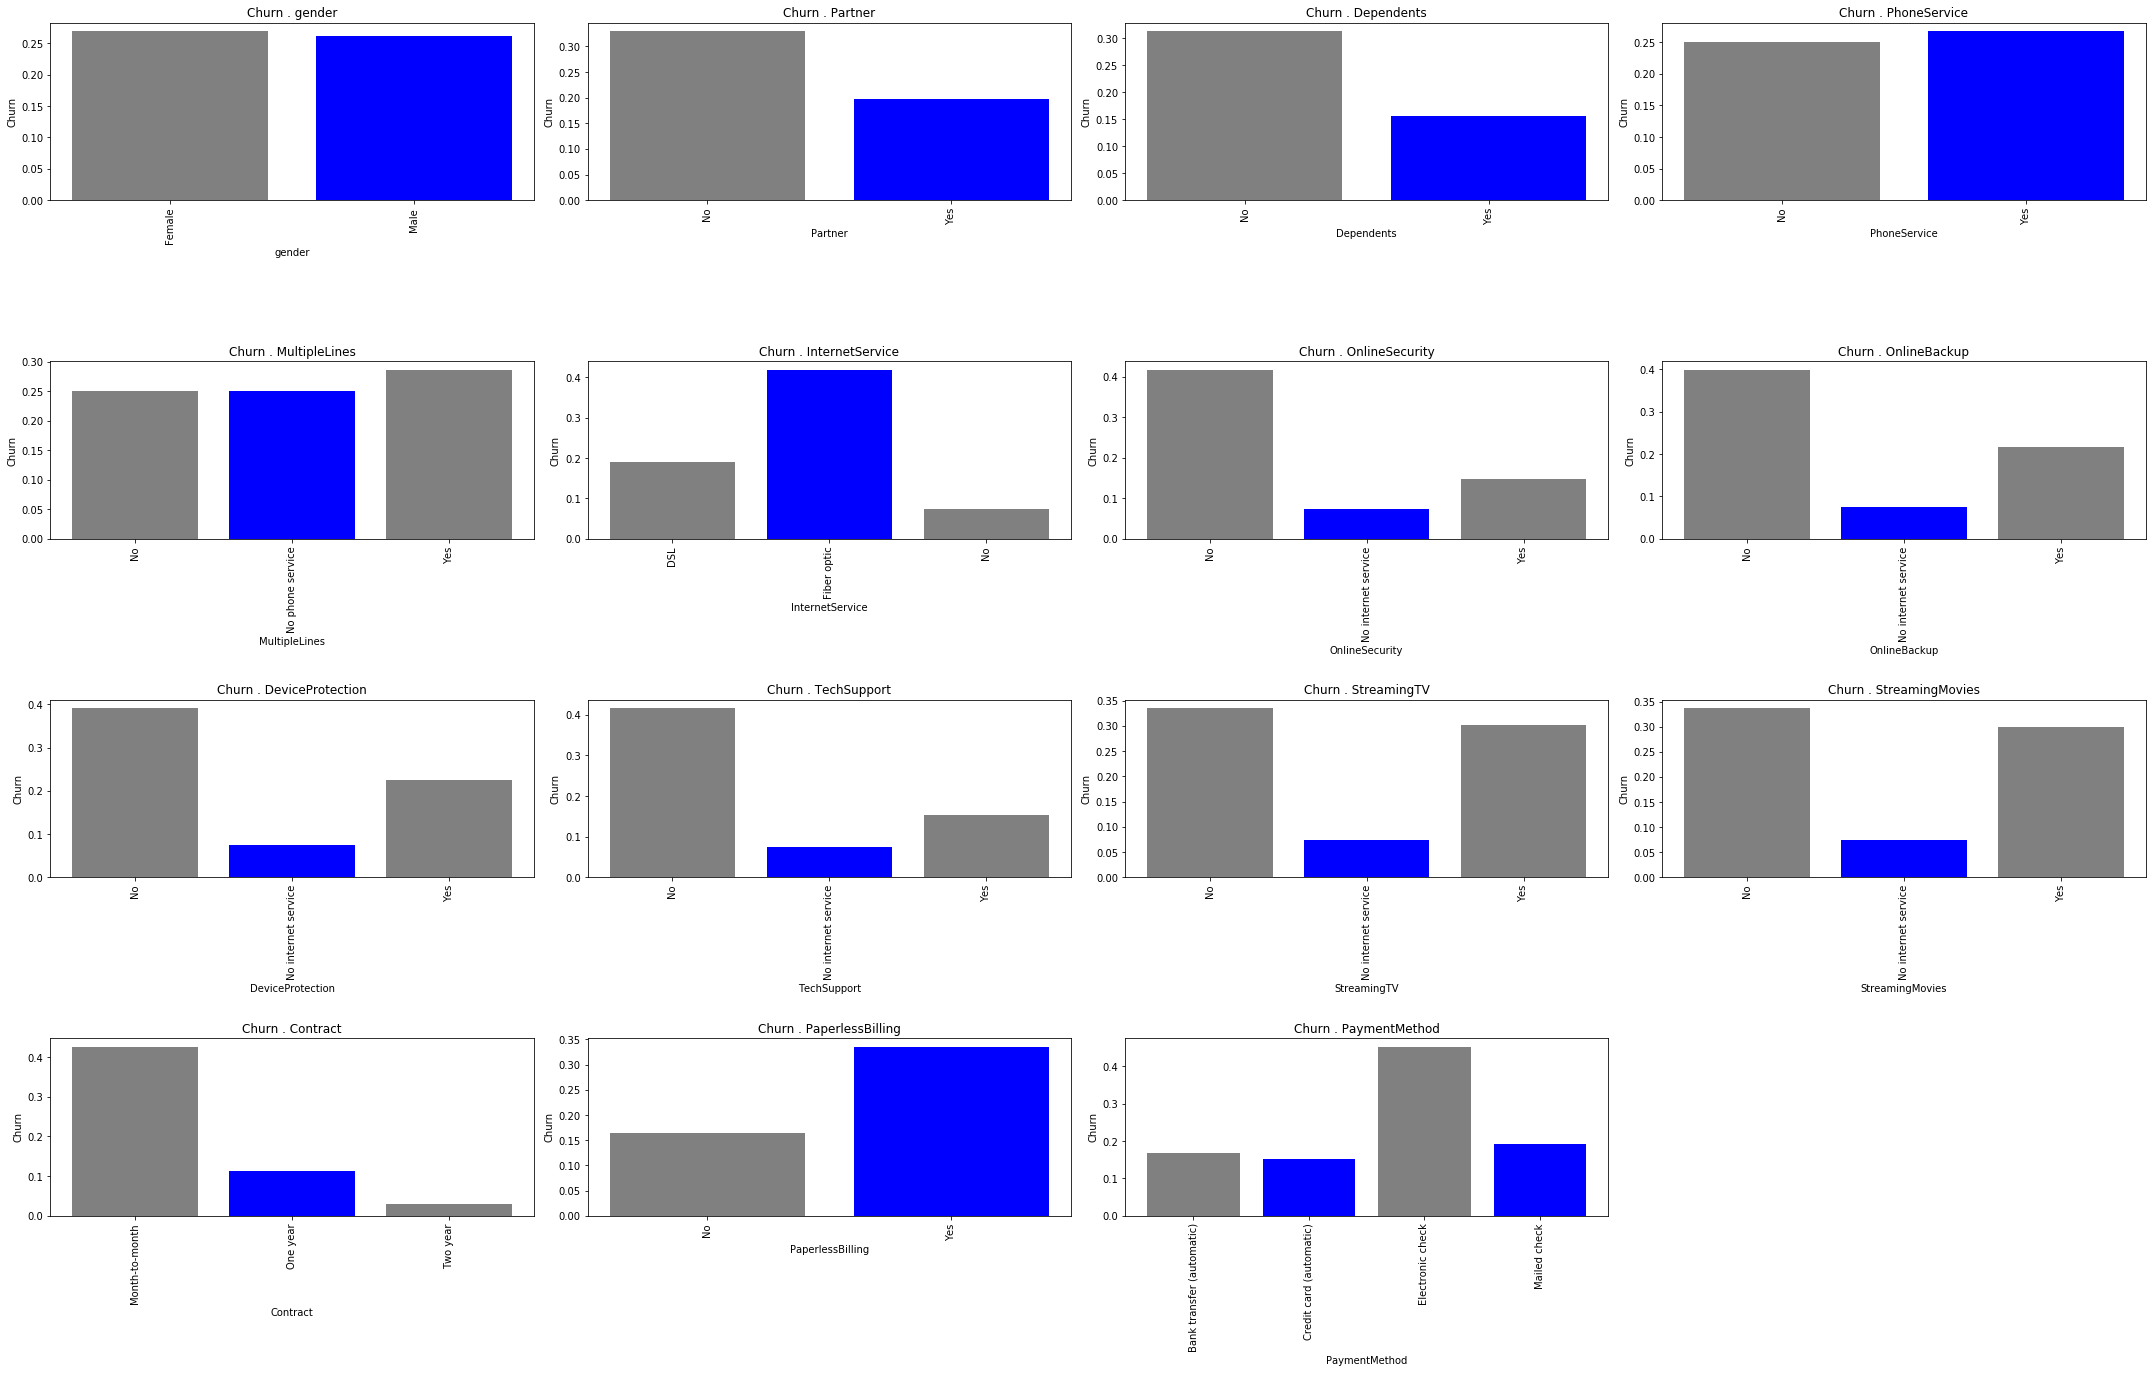

In [18]:
#plot categorical variables against churn
plt.figure(figsize=(30,50))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(11,4,index+1)
    plt.bar(churn_df.groupby(column)["churn_numeric"].mean().index, churn_df.groupby(column)["churn_numeric"].mean(),
           color=("grey","blue"))
    plt.title("Churn . {}".format(column))
    plt.ylabel("Churn")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

Gender and MultipleLines do not appear to vary along the target variable. I will drop these columns and create dummy variables for the remaining categorical variables.

In [19]:
#drop gender and multiplelines
churn_df = churn_df.drop(['gender', 'MultipleLines'], axis=1)

In order to work with the categorical variables, I have to create dummy variables for each. 

In [20]:
#one-hot encoding

churn_df = pd.concat([churn_df,pd.get_dummies(churn_df.Partner, prefix="Partner", drop_first=True)], axis=1)
churn_df = pd.concat([churn_df,pd.get_dummies(churn_df.Dependents, prefix="Dependents", drop_first=True)], axis=1)
churn_df = pd.concat([churn_df,pd.get_dummies(churn_df.PhoneService, prefix="PhoneService", drop_first=True)], axis=1)
churn_df = pd.concat([churn_df,pd.get_dummies(churn_df.InternetService, prefix="InternetService", drop_first=True)], axis=1)
churn_df = pd.concat([churn_df,pd.get_dummies(churn_df.OnlineSecurity, prefix="OnlineSecurity", drop_first=True)], axis=1)
churn_df = pd.concat([churn_df,pd.get_dummies(churn_df.OnlineBackup, prefix="OnlineBackup", drop_first=True)], axis=1)
churn_df = pd.concat([churn_df,pd.get_dummies(churn_df.DeviceProtection, prefix="DeviceProtection", drop_first=True)], axis=1)
churn_df = pd.concat([churn_df,pd.get_dummies(churn_df.TechSupport, prefix="TechSupport", drop_first=True)], axis=1)
churn_df = pd.concat([churn_df,pd.get_dummies(churn_df.StreamingTV, prefix="StreamingTV", drop_first=True)], axis=1)
churn_df = pd.concat([churn_df,pd.get_dummies(churn_df.StreamingMovies, prefix="StreamingMovies", drop_first=True)], axis=1)
churn_df = pd.concat([churn_df,pd.get_dummies(churn_df.Contract, prefix="Contract", drop_first=True)], axis=1)
churn_df = pd.concat([churn_df,pd.get_dummies(churn_df.PaperlessBilling, prefix="PaperlessBilling", drop_first=True)], axis=1)
churn_df = pd.concat([churn_df,pd.get_dummies(churn_df.PaymentMethod, prefix="PaymentMethod", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(churn_df.Partner, prefix="Partner", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(churn_df.Dependents, prefix="Dependents", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(churn_df.PhoneService, prefix="PhoneService", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(churn_df.InternetService, prefix="InternetService", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(churn_df.OnlineSecurity, prefix="OnlineSecurity", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(churn_df.OnlineBackup, prefix="OnlineBackup", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(churn_df.DeviceProtection, prefix="DeviceProtection", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(churn_df.TechSupport, prefix="TechSupport", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(churn_df.StreamingTV, prefix="StreamingTV", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(churn_df.StreamingMovies, prefix="StreamingMovies", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(churn_df.Contract, prefix="Contract", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(churn_df.PaperlessBilling, prefix="PaperlessBilling", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(churn_df.PaymentMethod, prefix="PaymentMethod", drop_first=True).columns)


Let's see how the target variable relates to the numeric variables using a correlation matrix

In [21]:
churn_df[numeric_columns].corr()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
SeniorCitizen,1.000000,0.015683,0.219874,0.102411
tenure,0.015683,1.000000,0.246862,0.825880
MonthlyCharges,0.219874,0.246862,1.000000,0.651065
TotalCharges,0.102411,0.825880,0.651065,1.000000


All the numeric variables are at least somewhat correlated with the target variable Churn. We will keep them all for now.

Unfortunately, the dataset is imbalanced. To address this, I will resample the data by under-sampling the majority class (randomly). This will unfortunately lead to a loss of some data but it is necessary to have a balanced dataset.


In [22]:
# Separate majority and minority classes
df_majority = churn_df[churn_df.churn_numeric==0]
df_minority = churn_df[churn_df.churn_numeric==1]
 
# Downsample majority class to a similar size as majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    
                                 n_samples=2200,    
                                 random_state=123)  
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.churn_numeric.value_counts()

0    2200
1    1869
Name: churn_numeric, dtype: int64

Text(0, 0.5, 'Number of Customers')

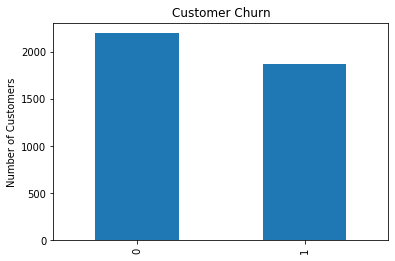

In [23]:
#plot new value counts
df_downsampled['churn_numeric'].value_counts().plot(kind='bar')
plt.title('Customer Churn')
plt.ylabel('Number of Customers')

In [24]:
#create X and Y
Y = df_downsampled['churn_numeric']
X = df_downsampled[['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'] + dummy_column_names]


#create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

Now that the exploratory data analysis is complete and the test and training sets have been created, I will move onto using SelectKBest with 6 different models to compare which model performs best. Then, I will use PCA to compare how it performs against SelectKBest.

# SelectKBest

In [25]:
#selectKbest to choose 13 most important features (80% of features)
best_features = SelectKBest(score_func=f_classif, k=13)
fit = best_features.fit(X,Y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)


# concatenate 
feature_scores = pd.concat([df_columns, df_scores],axis=1)
feature_scores.columns = ['Feature Name','Score'] 
print(feature_scores.nlargest(13,'Score')) 


                            Feature Name       Score
1                                 tenure  830.489943
22                     Contract_Two year  659.686531
7            InternetService_Fiber optic  497.952324
25        PaymentMethod_Electronic check  460.505423
8                     InternetService_No  314.728966
9     OnlineSecurity_No internet service  314.728966
11      OnlineBackup_No internet service  314.728966
13  DeviceProtection_No internet service  314.728966
15       TechSupport_No internet service  314.728966
17       StreamingTV_No internet service  314.728966
19   StreamingMovies_No internet service  314.728966
3                           TotalCharges  256.194632
23                  PaperlessBilling_Yes  206.958365


In [26]:
#update X
X = df_downsampled[[ 'tenure',  'TotalCharges', 'InternetService_Fiber optic', 'Contract_Two year', 'PaymentMethod_Electronic check', 'InternetService_No',
 'OnlineSecurity_No internet service', 'OnlineBackup_No internet service', 'DeviceProtection_No internet service', 'TechSupport_No internet service', 'StreamingTV_No internet service',
'StreamingMovies_No internet service', 'PaperlessBilling_Yes' ]]


### Logistic Regression with selectKbest

In [27]:
#fit and train a logistic regression
import warnings
warnings.filterwarnings('ignore')
lrm = LogisticRegression()
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_lrm_acc = GridSearchCV(lrm, param_grid = grid_values,scoring = 'recall')
grid_lrm_acc.fit(X_train, y_train)

#Predict values based on new parameters
y_pred = grid_lrm_acc.predict(X_test)

In [28]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
report = classification_report(y_test, y_pred, target_names=['Did Not Churn', 'Did Churn'])
print(report)
cv_scores = cross_val_score(grid_lrm_acc, X_train, y_train, cv = 5)

print('Mean cross validation score: {:.3f}'.format(np.mean(cv_scores)))
#Confusion matrix

print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

Accuracy Score : 0.7530712530712531
Precision Score : 0.7115384615384616
Recall Score : 0.7851458885941645
F1 Score : 0.7465321563682219
               precision    recall  f1-score   support

Did Not Churn       0.80      0.73      0.76       437
    Did Churn       0.71      0.79      0.75       377

     accuracy                           0.75       814
    macro avg       0.75      0.76      0.75       814
 weighted avg       0.76      0.75      0.75       814

Mean cross validation score: 0.767
Confusion Matrix : 
[[317 120]
 [ 81 296]]


The above metrics indicate that the selectKbest logistic regression model was 75.3% accurate. It correctly predicted 80% of the customers who did not churn, and it correctly predicted 71% of the customers who did churn. The confusion matrix tells me that there were 317 true positives and 296 true negatives, but there were 80 false negatives and 120 false positives. Overall, this model was satisfactory but can be improved.

 param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
>>> clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
>>> clf
GridSearchCV(cv=None,
       estimator=LogisticRegression(C=1.0, intercept_scaling=1, dual=False, fit_intercept=True,
          penalty='l2', tol=0.0001),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, verbose=0)
>>> clf = clf.fit(gt_features, labels)

### KNN with selectKbest

In [29]:
#KNN

knn = KNeighborsClassifier()
#dictionary with values I want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=5)
#fit model
knn_gscv.fit(X_train, y_train)

#Predict values 
y_pred = knn_gscv.predict(X_test)

In [30]:
#see how the model performed
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
report = classification_report(y_test, y_pred, target_names=['Did Not Churn', 'Did Churn'])
print(report)

cv_scores = cross_val_score(knn_gscv, X_train, y_train, cv = 5)

print('Mean cross validation score: {:.3f}'.format(np.mean(cv_scores)))
#Confusion matrix
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

Accuracy Score : 0.7199017199017199
Precision Score : 0.7008086253369272
Recall Score : 0.6896551724137931
F1 Score : 0.6951871657754011
               precision    recall  f1-score   support

Did Not Churn       0.74      0.75      0.74       437
    Did Churn       0.70      0.69      0.70       377

     accuracy                           0.72       814
    macro avg       0.72      0.72      0.72       814
 weighted avg       0.72      0.72      0.72       814

Mean cross validation score: 0.712
Confusion Matrix : 
[[326 111]
 [117 260]]


The KNN model using selectKbest was 71.9% accurate. Its precision for the customers who did not churn was 74% while its precision for customers did churn was a little lower at 70%. The average cross validation score was .712, which is not great. The confusion matrix indicates that there were 326 true positives and 260 true negatives, but there were 117 false negatives and 111 false positives. Overall, this model is also just satisfactory and there is room for improvement.

### Decision Tree with selectKbest

In [31]:
#fit the tree using the best parameters (determined by gridsearch)
tree_para = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
clf = GridSearchCV(DecisionTreeClassifier(), tree_para, cv=5)
clf.fit(X_train, y_train)
#Predict values 
y_pred = clf.predict(X_test)

In [32]:
#see how the model performed
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
report = classification_report(y_test, y_pred, target_names=['Did Not Churn', 'Did Churn'])
print(report)
cv_scores = cross_val_score(clf, X_train, y_train, cv = 5)

print('Mean cross validation score: {:.3f}'.format(np.mean(cv_scores)))
#Confusion matrix
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

Accuracy Score : 0.7542997542997543
Precision Score : 0.697986577181208
Recall Score : 0.8275862068965517
F1 Score : 0.7572815533980581
               precision    recall  f1-score   support

Did Not Churn       0.82      0.69      0.75       437
    Did Churn       0.70      0.83      0.76       377

     accuracy                           0.75       814
    macro avg       0.76      0.76      0.75       814
 weighted avg       0.77      0.75      0.75       814

Mean cross validation score: 0.747
Confusion Matrix : 
[[302 135]
 [ 65 312]]


The decision tree with selectKbest was slightly more accurate than the first two models at 75.4%. This model had an 82% precision rate for the customers who did not churn and a 70% precision rate for customers who did churn. The average cross validation score was .747, which could be better. There were 302 true positives, 312 true negatives, 65 false negatives, and 135 false negatives. An accuracy of 75.4% is fine, but there is still room for improvement.

### Random Forest with selectKbest

In [33]:
#fit the RF using the parameters chosen by gridsearch
tree_para = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
clf = GridSearchCV(RandomForestClassifier(), tree_para, cv=5)
clf.fit(X_train, y_train)
#Predict values 
y_pred = clf.predict(X_test)


In [34]:
#see how the model performed
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
report = classification_report(y_test, y_pred, target_names=['Did Not Churn', 'Did Churn'])
print(report)

cv_scores = cross_val_score(clf, X_train, y_train, cv = 5)

print('Mean cross validation score: {:.3f}'.format(np.mean(cv_scores)))
#Confusion matrix
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

Accuracy Score : 0.7481572481572482
Precision Score : 0.7057416267942583
Recall Score : 0.7824933687002652
F1 Score : 0.7421383647798743
               precision    recall  f1-score   support

Did Not Churn       0.79      0.72      0.75       437
    Did Churn       0.71      0.78      0.74       377

     accuracy                           0.75       814
    macro avg       0.75      0.75      0.75       814
 weighted avg       0.75      0.75      0.75       814

Mean cross validation score: 0.758
Confusion Matrix : 
[[314 123]
 [ 82 295]]


The random forest with selectKbest had an accuracy rate of 74.8%. Its precision scores for the did not churn and did churn categories, which were 79% and 71%, respectively. The mean cross validation score for the random forest model was .758, which is satisfactory but needs to be improved.

### Support Vector Classifier with selectKbest

In [35]:
# define parameter range 
param_grid = {'C': [0.001, 0.1, 1, 5,  10, 50, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
#grid search with svc model  
grid_svc = GridSearchCV(SVC(), param_grid, refit = True, verbose = False) 
  
# fit the model for grid search 
grid_svc.fit(X_train, y_train)
#Predict values 
y_pred = grid_svc.predict(X_test)

In [36]:
#see how the model performed
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
report = classification_report(y_test, y_pred, target_names=['Did Not Churn', 'Did Churn'])
print(report)

cv_scores = cross_val_score(grid_svc, X_train, y_train, cv = 5)

print('Mean cross validation score: {:.3f}'.format(np.mean(cv_scores)))
#Confusion matrix
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

Accuracy Score : 0.7334152334152334
Precision Score : 0.7061855670103093
Recall Score : 0.726790450928382
F1 Score : 0.7163398692810458
               precision    recall  f1-score   support

Did Not Churn       0.76      0.74      0.75       437
    Did Churn       0.71      0.73      0.72       377

     accuracy                           0.73       814
    macro avg       0.73      0.73      0.73       814
 weighted avg       0.73      0.73      0.73       814

Mean cross validation score: 0.720
Confusion Matrix : 
[[323 114]
 [103 274]]


The support vector model (with selectKbest) had a slightly lower accuracy score, at 73.3%. This model had a lower precision rate for the 'did not churn' category than a few other models, at only 76%. The average cross validation score was also a little lower than a few other models, at .72. The SVC model had a larger number of false negatives and false positives than several other models, with 103 false negatives and 114 false positives.

### Gradient Boosting with selectKbest

In [37]:
gbc = GradientBoostingClassifier()
#choose parameters to test
parameters = {
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}
#fit GB model for gridsearch
cv = GridSearchCV(gbc,parameters,cv=5)
cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort=

In [38]:
y_pred = cv.predict(X_test)
#see how the model performed
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
report = classification_report(y_test, y_pred, target_names=['Did Not Churn', 'Did Churn'])
print(report)

cv_scores = cross_val_score(cv, X_train, y_train, cv = 5)

print('Mean cross validation score: {:.3f}'.format(np.mean(cv_scores)))
#Confusion matrix
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

Accuracy Score : 0.7518427518427518
Precision Score : 0.7058823529411765
Recall Score : 0.7957559681697612
F1 Score : 0.7481296758104738
               precision    recall  f1-score   support

Did Not Churn       0.80      0.71      0.76       437
    Did Churn       0.71      0.80      0.75       377

     accuracy                           0.75       814
    macro avg       0.75      0.75      0.75       814
 weighted avg       0.76      0.75      0.75       814

Mean cross validation score: 0.765
Confusion Matrix : 
[[312 125]
 [ 77 300]]


The gradient boosting model (using selectKbest) had a decent accuracy score of 75.2%. Its precision rate for the customers who did not churn was 80%, which is fine, but its precision rate for customers who did churn was only 71%. The mean cross validation score for the gradient boosting was slightly better than most models, at .765. The confusion matrix indicates that this model predicted categories better than a few other models, with 312 true positives, 300 true negatives, 125 false positives, and 77 false negatives.

# PCA  

Now, I want to compare how well the same 6 models perform after using PCA (in comparison to selectKbest). First, I will apply the PCA technique to the data to determine how many components to keep (based on cumulative explained variable). Then, I will use these components in the 6 models. 

In [39]:
#standardize and transform X
X_standard = StandardScaler().fit_transform(X)

Text(0, 0.5, 'Explained Variance')

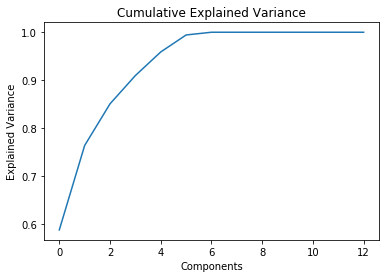

In [40]:
pca = PCA().fit(X_standard)
#look at variance explained by PCA components
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative Explained Variance')
plt.xlabel('Components')
plt.ylabel('Explained Variance')

In [41]:
print(
    'The percentage of total variance in the dataset explained by each component:',
   pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component: [5.88554516e-001 1.75741745e-001 8.67057975e-002 5.88743708e-002
 4.91112593e-002 3.53486895e-002 5.66362171e-003 8.92285612e-035
 2.05232959e-037 1.23476740e-068 1.90503845e-070 1.42821254e-103
 6.82262721e-107]


The results indicate that the first 5 components explain more than 90% of the variance. I will use the first five components in PCA, train the models, test the models.

In [42]:
#use 5 components in PCA
pca = PCA(n_components=5)
X_PCA = pca.fit_transform(X_standard)
#look at explained variance
pca_variance = pca.explained_variance_ratio_
print('Cumulative Explained Variance: ', pca.explained_variance_ratio_.sum())
print('Percentage of total variance explained by each component:',
    pca.explained_variance_ratio_
)


Cumulative Explained Variance:  0.9589876887393142
Percentage of total variance explained by each component: [0.58855452 0.17574174 0.0867058  0.05887437 0.04911126]


In [43]:
#PCA as a dataframe
PCA_df = pd.DataFrame(X_PCA)
#split data based on PCA
X_train, X_test, y_train, y_test = train_test_split(PCA_df, Y, test_size = 0.2, random_state = 465)

Now that I have the 5 best components and test/training sets, I will fit the 6 models.

### Logistic Regression with PCA 

In [44]:
#fit a logistic regression
lrm = LogisticRegression()
#grid search to find best parameters
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_lrm_acc = GridSearchCV(lrm, param_grid = grid_values,scoring = 'recall')
grid_lrm_acc.fit(X_train, y_train)

#Predict values based on best parameters
y_pred = grid_lrm_acc.predict(X_test)

In [45]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
report = classification_report(y_test, y_pred, target_names=['Did Not Churn', 'Did Churn'])
print(report)

cv_scores = cross_val_score(grid_lrm_acc, X_train, y_train, cv = 5)
print('Mean cross validation score: {:.3f}'.format(np.mean(cv_scores)))
#Logistic Regression Classifier Confusion matrix

print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

Accuracy Score : 0.730958230958231
Precision Score : 0.6652719665271967
Recall Score : 0.843501326259947
F1 Score : 0.7438596491228071
               precision    recall  f1-score   support

Did Not Churn       0.82      0.63      0.72       437
    Did Churn       0.67      0.84      0.74       377

     accuracy                           0.73       814
    macro avg       0.74      0.74      0.73       814
 weighted avg       0.75      0.73      0.73       814

Mean cross validation score: 0.815
Confusion Matrix : 
[[277 160]
 [ 59 318]]


The PCA logistic regression (73.1%) was slightly less accurate than the selectKbest logistic regression (75.4%). However, this model had a higher mean cross validation score (.815) in comparison to the selectKbest logistic regression (.767). Therefore, while this model might not have quite as high an accuracy score, it is more consistent across training sets.

### K-Nearest Neighbors with PCA

In [46]:
knn = KNeighborsClassifier()
#dictionary with all n_neighbors values to test for
param_grid = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values 
knn_gscv = GridSearchCV(knn, param_grid, cv=5)
#fit model to data
knn_gscv.fit(X_train, y_train)

#Predict values 
y_pred = knn_gscv.predict(X_test)

In [47]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
report = classification_report(y_test, y_pred, target_names=['Did Not Churn', 'Did Churn'])
print(report)


cv_scores = cross_val_score(knn_gscv, X_train, y_train, cv = 5)

print('Mean cross validation score: {:.3f}'.format(np.mean(cv_scores)))
# Confusion matrix
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

Accuracy Score : 0.7653562653562653
Precision Score : 0.7348484848484849
Recall Score : 0.7718832891246684
F1 Score : 0.7529107373868046
               precision    recall  f1-score   support

Did Not Churn       0.79      0.76      0.78       437
    Did Churn       0.73      0.77      0.75       377

     accuracy                           0.77       814
    macro avg       0.76      0.77      0.76       814
 weighted avg       0.77      0.77      0.77       814

Mean cross validation score: 0.739
Confusion Matrix : 
[[332 105]
 [ 86 291]]


The PCA KNN model had a decent accuracy score (76.5%) and this was better than the selectKbest KNN (72%). Its precision score for the customers who did not churn was 79%, which is a little lower than most of the other models. However, its precision score for the customers who did churn was 73%, which is higher than most other models. The cross validation score was only satisfactory at .739, which is lower than several other models.

### Decision Tree with PCA

In [48]:
#possible parameters
tree_para = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
clf = GridSearchCV(DecisionTreeClassifier(), tree_para, cv=5)
clf.fit(X_train, y_train)
#Predict values 
y_pred = clf.predict(X_test)

In [49]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
report = classification_report(y_test, y_pred, target_names=['Did Not Churn', 'Did Churn'])
print(report)
cv_scores = cross_val_score(clf, X_train, y_train, cv = 5)

print('Mean cross validation score: {:.3f}'.format(np.mean(cv_scores)))
#Confusion matrix
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

Accuracy Score : 0.7432432432432432
Precision Score : 0.6891891891891891
Recall Score : 0.8116710875331565
F1 Score : 0.7454323995127893
               precision    recall  f1-score   support

Did Not Churn       0.81      0.68      0.74       437
    Did Churn       0.69      0.81      0.75       377

     accuracy                           0.74       814
    macro avg       0.75      0.75      0.74       814
 weighted avg       0.75      0.74      0.74       814

Mean cross validation score: 0.744
Confusion Matrix : 
[[299 138]
 [ 71 306]]


The PCA decision tree had a slightly lower accuracy score, at 74.3%. The selectKbest decision tree had a higher accuracy score (75.4%). Its precision scores were close to most other models (81% and 69%). The cross validation score was just satisfactory and similar to other models (.744). The model had 299 true positives, 306 true negatives, 71 false negatives, and 138 true positives.

### Random Forest with PCA

In [50]:
#set all the possible parameters
tree_para = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
#search for best parameters
clf = GridSearchCV(RandomForestClassifier(), tree_para, cv=5)
clf.fit(X_train, y_train)
#Predict values 
y_pred = clf.predict(X_test)

In [51]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
report = classification_report(y_test, y_pred, target_names=['Did Not Churn', 'Did Churn'])
print(report)
cv_scores = cross_val_score(clf, X_train, y_train, cv = 5)

print('Mean cross validation score: {:.3f}'.format(np.mean(cv_scores)))
#Confusion matrix
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

Accuracy Score : 0.7665847665847666
Precision Score : 0.7286063569682152
Recall Score : 0.7904509283819628
F1 Score : 0.7582697201017812
               precision    recall  f1-score   support

Did Not Churn       0.80      0.75      0.77       437
    Did Churn       0.73      0.79      0.76       377

     accuracy                           0.77       814
    macro avg       0.77      0.77      0.77       814
 weighted avg       0.77      0.77      0.77       814

Mean cross validation score: 0.743
Confusion Matrix : 
[[326 111]
 [ 79 298]]


The PCA Random Forest model had a satisfactory accuracy rate (76.7%). The model's precision rate for customers who did not churn was 80% and its precision rate for customers who did churn was 73%, both slightly higher than several other models. The cross validation score was satisfactory (.743) but this could be improved. However, this is a similar score to most other models.

### Support Vector Classifier with PCA

In [56]:
# define parameter range 
param_grid = {'C': [0.001, 0.1, 1, 5,  10, 50, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
#grid search for best parameters
grid_svc = GridSearchCV(SVC(), param_grid, refit = True, verbose = False) 
  
# fit the model for grid search 
grid_svc.fit(X_train, y_train)
#Predict values 
y_pred = grid_svc.predict(X_test)

In [57]:

print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
report = classification_report(y_test, y_pred, target_names=['Did Not Churn', 'Did Churn'])
print(report)
cv_scores = cross_val_score(grid_svc, X_train, y_train, cv = 5)

print('Mean cross validation score: {:.3f}'.format(np.mean(cv_scores)))
#Confusion matrix
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

Accuracy Score : 0.769041769041769
Precision Score : 0.727710843373494
Recall Score : 0.8010610079575596
F1 Score : 0.7626262626262627
               precision    recall  f1-score   support

Did Not Churn       0.81      0.74      0.78       437
    Did Churn       0.73      0.80      0.76       377

     accuracy                           0.77       814
    macro avg       0.77      0.77      0.77       814
 weighted avg       0.77      0.77      0.77       814

Mean cross validation score: 0.747
Confusion Matrix : 
[[324 113]
 [ 75 302]]


The PCA SVC model had the best accuracy score of all PCA models, with 77%. This score is also higher than the selectKbest SVC model (73%). The individual precision rates were also decent, with 81% for customers who did not churn and 73% for customers who did churn. These numbers are reflected in the confusion matrix, which indicates that the model had 324 true positives, 302 true negatives, 75 false negatives, and 113 false positives. The mean cross validation score is also comparable to most models, at .747.

### Gradient Boosting with PCA

In [54]:
gbc = GradientBoostingClassifier()
#define possible parameters
parameters = {
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}
#grid search for best parameters
cv = GridSearchCV(gbc,parameters,cv=5)
cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort=

In [55]:
y_pred = cv.predict(X_test)
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
report = classification_report(y_test, y_pred, target_names=['Did Not Churn', 'Did Churn'])
print(report)
cv_scores = cross_val_score(gbc, X_train, y_train, cv = 5)

print('Mean cross validation score: {:.3f}'.format(np.mean(cv_scores)))
#Confusion matrix
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

Accuracy Score : 0.757985257985258
Precision Score : 0.7205882352941176
Recall Score : 0.7798408488063661
F1 Score : 0.7490445859872612
               precision    recall  f1-score   support

Did Not Churn       0.80      0.74      0.77       437
    Did Churn       0.72      0.78      0.75       377

     accuracy                           0.76       814
    macro avg       0.76      0.76      0.76       814
 weighted avg       0.76      0.76      0.76       814

Mean cross validation score: 0.745
Confusion Matrix : 
[[323 114]
 [ 83 294]]


The PCA gradient boosted model had a decent accuracy score (.758), which is very similar to the selectKbest gradient boosted model score (75.2%). Its precision rate for customers who did not churn and did churn were .80 and .72, respectively. The mean cross validation score was similar to most other models, at .745. 

## Summary

Overall, the models that used PCA and the ones that used selectKbest performed similarly. While there was some variation across models based on whether selectKbest or PCA was used, the differences were small. The model with the best accuracy score was the PCA SVC (77%), though the PCA Random Forest model was close (76.7%). The selectKbest decision tree model and the PCA logistic regression had the best precision rates for the customers who did not churn (82%), while the PCA random forest model had a better precision rate for the customers who did churn (73%). Both logistic regressions had the highest mean cross validation scores (.767 and .815), indicating that these models were the most consist across training/test sets.   

Overall, these results indicate to me that either PCA or selectKbest can be used to determine which features (or components) should be used in a model. Beyond that, each model has its pros/cons. The PCA support vector model was the most accurate, but the logistic regressions both had the highest cross validation scores. The data scientist should weigh these pros/cons when choosing a model. To best predict whether or not a customer will leave the company, however, the data scientist should consider adding more variables to the dataframe to improve the prediction accuracy.